In [1]:
#from shapely.geometry import Point
from functools import reduce
from faker import Faker
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd
import datetime
import random
import pprint
import bcrypt
#import click
import time
import json
import pytz
%matplotlib inline

pp = pprint.PrettyPrinter(indent=2)

In [2]:
def sort_subreddits(filename, sort_with):
    profile_pics = {}
    with open(filename, 'r') as subreddit_file:
        subs = json.load(subreddit_file)
        for k,v in sort_with.items():
            profile_pics[k] = reduce(lambda x,y: list(set(x + subs[y])), v, [])
    return profile_pics

def sexual_orientation():
    orientation = [
        'heterosexual',
        'homosexual',
        'bisexual']
    return np.random.choice(orientation, p=[0.6, 0.2, 0.2])


looking_for = {
    "male": {
        "heterosexual": "{female}",
        "homosexual": "{male}",
        "bisexual": "{male,female}",
    },
    "female": {
        "heterosexual": "{male}",
        "homosexual": "{female}",
        "bisexual": "{male,female}",
    }
} 

In [11]:
def profile_pic_generator():
    subreddit_genders = {
        'female': ['catpictures', 'blep'],
        'male': ['dogpictures', 'blop']
    }
    profile_pics = sort_subreddits('./blep_catpictures_blop_dogpictures.json', subreddit_genders)
    length = {'male': len(profile_pics['male']),
              'female': len(profile_pics['female'])}
    counter = {'male': 0,
               'female': 0}
    def next_profile_pic(gender):
        if gender not in ['male', 'female']:
            return ''
        picture_url = profile_pics[gender][counter[gender] % length[gender]]
        counter[gender] += 1
        return picture_url
    return next_profile_pic

In [12]:
def generate_age_distribution(min_age = 18, max_age = 77, size = 1000):
    ages = 13 + 12 * np.random.lognormal(0, 0.42, size = size)
    return np.clip(ages, min_age, max_age)

def plot_distribution(dist):
    print("min:", min(dist))
    print("max:", max(dist))
    num_bins = 2 * int(max(dist) - min(dist))
    plt.hist(dist, bins = num_bins if num_bins < 420 else 420)
    plt.show()

min: 18.0
max: 61.94134341928026


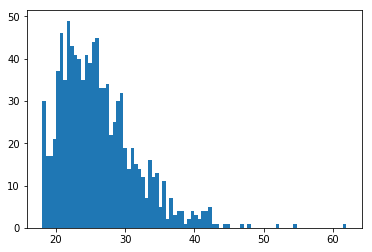

In [13]:
ages = generate_age_distribution()
plot_distribution(ages)

In [14]:
def generate_date_of_birth(min_age = 18, max_age = 77, size = 1000):
    tz = pytz.timezone('Europe/Paris')
    ages = generate_age_distribution(min_age, max_age, size)
    now = datetime.datetime.now(tz)
    dob = [(now - datetime.timedelta(days = int(366 * age))).strftime(format="%Y-%m-%d %H:%M:%S%z") for age in ages]
    return dob

In [15]:
dob = generate_date_of_birth(size=10)
print(dob)

['1992-07-28 01:49:14+0200', '1990-05-30 01:49:14+0200', '1996-01-08 01:49:14+0200', '1989-10-05 01:49:14+0200', '1994-06-17 01:49:14+0200', '1980-05-23 01:49:14+0200', '1991-08-01 01:49:14+0200', '1990-02-20 01:49:14+0200', '1994-07-03 01:49:14+0200', '1994-06-14 01:49:14+0200']


min: 2.864936095524075
max: 5242.559585710882


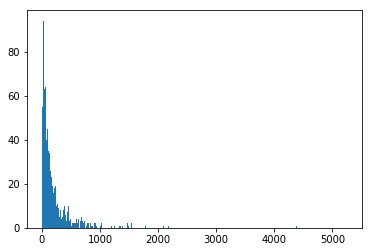

In [16]:
def generate_minutes_distribution(size = 1000):
    minutes = 100 * np.random.lognormal(0, 1.2, size = size)
    return minutes

plot_distribution(generate_minutes_distribution())

In [17]:
def generate_last_seen(size = 1000):
    tz = pytz.timezone('Europe/Paris')
    minutes = generate_minutes_distribution(size = size)
    now = datetime.datetime.now(tz)
    last_seen = [(now - datetime.timedelta(seconds = int(60 * minute))).strftime(format="%Y-%m-%d %H:%M:%S%z") for minute in minutes]
    return last_seen

In [18]:
def generate_fake_profiles(size = 1000):
    start = time.time()
    fake = Faker('fr_FR')
    next_profile_pic = profile_pic_generator()
    hashed_password = bcrypt.hashpw("auie".encode('utf-8'), bcrypt.gensalt(10))
    profiles = []
    
    for _ in tqdm(range(size)):
        profile = fake.profile()
        profile['hashed_password'] = hashed_password
        name = profile['name'].split(' ')
        profile['firstname'] = name[0]
        profile['lastname'] = ' '.join(name[1:])
        profile['gender'] = 'male' if profile['sex'] == 'M' else 'female'
        profile['sexual_orientation'] = sexual_orientation()
        profile['lookingfor'] = looking_for[profile['gender']][profile['sexual_orientation']]
        profile['bio'] = fake.text(max_nb_chars = 200)
        profile['num_pics'] = 1
        profile['url_pp'] = next_profile_pic(profile['gender'])
        profile['email'] = profile['mail']
        lon, lat = fake.local_latlng(country_code="FR", coords_only=True)
        profile['location'] =  '(' + lat + ',' + lon + ')'
        profile['popularity_score'] = random.randrange(100)
        profile['verified'] = True
        profile.pop('mail')
        profile.pop('birthdate')
        profile.pop('blood_group')
        profile.pop('address')
        profile.pop('company')
        profile.pop('job')
        profile.pop('name')
        profile.pop('residence')
        profile.pop('sex')
        profile.pop('ssn')
        profile.pop('website')
        profile.pop('current_location')
        profiles.append(profile)
        
    df = pd.DataFrame(profiles)
    df['date_of_birth'] = generate_date_of_birth(min_age = 18, max_age = 77, size = size)
    df['last_seen'] = generate_last_seen(size = size)
    original_length = len(df)
    df = df.drop_duplicates('username')
    df = df.drop_duplicates('email')
    num_duplicated = original_length - len(df)
    if (num_duplicated):
        print("dropped {} row(s) (duplicated email or username)".format(num_duplicated))
    return df


In [19]:
df = generate_fake_profiles(size = 1000)

100%|██████████| 1000/1000 [00:03<00:00, 306.04it/s]


dropped 1 row(s) (duplicated email or username)


In [20]:
df.head()

,bio,email,firstname,gender,hashed_password,lastname,location,lookingfor,num_pics,popularity_score,sexual_orientation,url_pp,username,verified,date_of_birth,last_seen
0,Travail point bien serrer repousser. Pur diffé...,anaisguerin@hotmail.fr,Maurice,male,$2a$10$0RsOGUbpqMBUSvYv8v7.LuSIHMOl/Q85zBloE1w...,Joly,"(8.73812,41.91886)","{male,female}",1,48,bisexual,https://i.imgur.com/fSVPU9R.jpg,claudineleclerc,True,1982-01-14 01:49:22+0200,2019-05-15 19:01:55+0200
1,Sauter fleur jeter écouter sueur air. Relever ...,rleger@club-internet.fr,Grégoire-Stéphane,male,$2a$10$0RsOGUbpqMBUSvYv8v7.LuSIHMOl/Q85zBloE1w...,Maury,"(2.1699,48.98994)",{female},1,38,heterosexual,https://i.imgur.com/lDP6S70.jpg,adampauline,True,1999-04-15 01:49:22+0200,2019-05-15 21:29:44+0200
2,Lequel voici grandir moi figure. Comme relatio...,irodriguez@sfr.fr,Grégoire,male,$2a$10$0RsOGUbpqMBUSvYv8v7.LuSIHMOl/Q85zBloE1w...,Barbier,"(2.18967,48.8765)",{female},1,3,heterosexual,http://i.imgur.com/6fwQvXu.jpg,agneslaunay,True,1980-02-17 01:49:22+0200,2019-05-15 15:52:58+0200
3,Digne curiosité moindre signifier demain coule...,guillonauguste@tele2.fr,Victoire,female,$2a$10$0RsOGUbpqMBUSvYv8v7.LuSIHMOl/Q85zBloE1w...,Mendes de Guillon,"(5.4584,43.32393)",{male},1,19,heterosexual,http://i.imgur.com/5EAt3pj.jpg,agneslefebvre,True,1992-07-10 01:49:22+0200,2019-05-16 01:07:21+0200
4,Ajouter assez sombre corde. Dos grâce souffler...,margaud19@bouygtel.fr,Brigitte-Élisabeth,female,$2a$10$0RsOGUbpqMBUSvYv8v7.LuSIHMOl/Q85zBloE1w...,Martin,"(2.61667,48.98333)",{male},1,19,heterosexual,https://imgur.com/23fZYtM.jpg,nrodriguez,True,1997-02-26 01:49:22+0200,2019-05-15 22:36:43+0200


In [13]:
#df.to_csv("../db/fake_profiles.csv", sep = ';', index_label = 'id')
df.to_csv("../db/fake_profiles.csv", sep = ';', index = False)